In [62]:
import pandas as pd
from datetime import datetime

weather_data_filepath = "data/weather_data.csv"
electricity_data_filepath = "data/electricity_production_data.csv"

df_weather = pd.read_csv(weather_data_filepath, delimiter=',')
df_electricity = pd.read_csv(electricity_data_filepath, delimiter=',')

df_weather['time'] = pd.to_datetime(df_weather['referenceTime'])
df_weather['time'] = df_weather['time'].dt.tz_localize(None)
df_electricity['time'] = pd.to_datetime(df_electricity['måned'], format='%YM%m')
df_weather = df_weather.drop(columns="referenceTime")
df_electricity = df_electricity.drop(columns="måned")

df_weather['month_year'] = df_weather['time'].dt.strftime('%Y-%m')
df_electricity['month_year'] = df_electricity['time'].dt.strftime('%Y-%m')

df_merged = pd.merge(df_weather.drop(columns="time"), df_electricity.drop(columns="time"), on="month_year", suffixes=["_precipitation", "_electricity"], how="outer")
df_merged.sort_values(by='month_year', inplace=True)

def get_cropped_df(df, start_year, end_year):
    df['month_year'] = pd.to_datetime(df['month_year'], format='%Y-%m')
    cropped_df_merged = df[(df['month_year'].dt.year >= start_year) & (df['month_year'].dt.year <= end_year)]
    cropped_df_merged.reset_index(drop=True, inplace=True)
    return cropped_df_merged

df_merged_all_values = df_merged.dropna()
df_merged_all_values['month_year'] = pd.to_datetime(df_merged_all_values['month_year'])
df_merged_all_values.set_index('month_year', inplace=True)


/var/folders/d7/j_29bjyn0_lbt66yfhsy0pf00000gp/T/ipykernel_15054/176743871.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_all_values['month_year'] = pd.to_datetime(df_merged_all_values['month_year'])


In [63]:
from statsmodels.tsa.arima.model import ARIMA

#-----------PARAMS--------------#
AR_LAG = 6
MA_LAG = 3
DIFFERENCING = 0
order=(AR_LAG,DIFFERENCING,MA_LAG)
exog=df_merged_all_values['value_precipitation']
params = {'order': order, 'exog': exog}

#################################


model = ARIMA(df_merged_all_values['value_electricity'], **params)
model_fit = model.fit()

/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

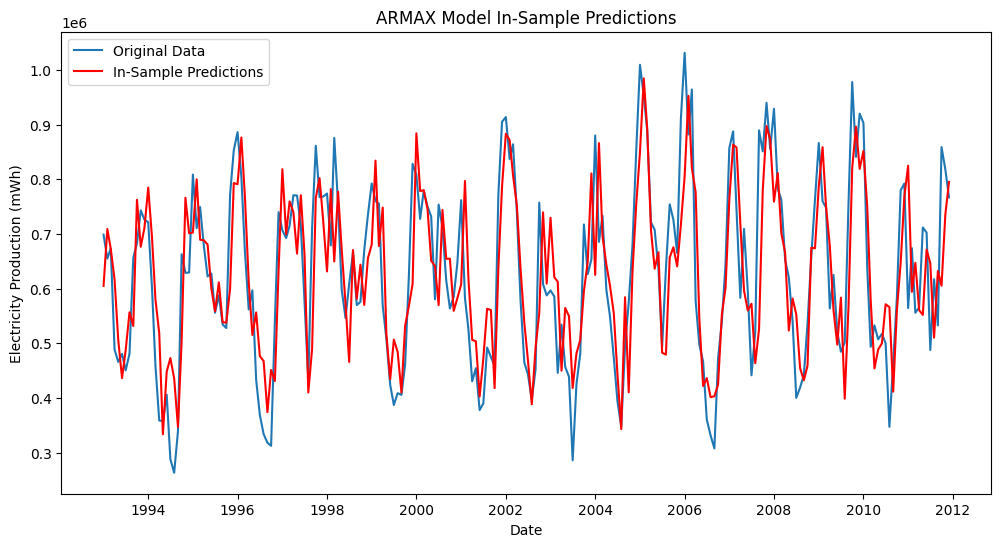

In [64]:
import matplotlib.pyplot as plt

in_sample_predictions = model_fit.predict(start=0, end=len(df_merged_all_values)-1, dynamic=False)
# Plot the original data and the in-sample predictions
plt.figure(figsize=(12, 6))
plt.plot(df_merged_all_values['value_electricity'], label='Original Data')
plt.plot(in_sample_predictions, label='In-Sample Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Production (mWh)')
plt.title('ARMAX Model In-Sample Predictions')
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = df_merged_all_values['value_electricity'].values

TRAIN_SIZE = 0.5
train_size = int(len(X)*TRAIN_SIZE)
train, test = X[0:train_size], X[train_size:len(X)]
history = [x for x in train]
preds = list()

for t in range(len(test)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"predicted={yhat}, expected={obs}")

rmse = sqrt(mean_squared_error(test, preds))
print('Test RMSE: %.3f' % rmse)

/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=417253.08571664593, expected=442725.0
predicted=423863.03971198725, expected=396303.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=432638.33999777137, expected=452819.0
predicted=498248.041071221, expected=757460.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=790894.0474825356, expected=607919.0
predicted=615920.1545547483, expected=587561.0
predicted=643392.763210781, expected=596684.0
predicted=638600.5275012442, expected=585460.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=592645.2055986585, expected=445714.0
predicted=445446.96563341905, expected=534191.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=592642.5870643305, expected=456715.0
predicted=448000.9725356274, expected=438692.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=506331.109048335, expected=285695.0
predicted=326938.88559181296, expected=424914.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=521160.7014774258, expected=480828.0
predicted=555899.376304304, expected=717458.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=782573.6096785926, expected=626537.0
predicted=707205.0739560734, expected=653455.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=659445.663813693, expected=880304.0
predicted=859470.1192481878, expected=685545.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=622091.3721470243, expected=733240.0
predicted=659739.0679888062, expected=598568.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=500214.739762048, expected=548935.0
predicted=476754.50131266034, expected=473402.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=435516.95178477175, expected=393641.0
predicted=427392.108446343, expected=347585.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=448784.2131450367, expected=494536.0
predicted=589979.8620999766, expected=574641.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=658555.7688783697, expected=680647.0
predicted=745081.0545347568, expected=849966.0
predicted=848808.5098889896, expected=1009743.0
predicted=917309.2691560814, expected=952440.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=842909.1706361027, expected=889917.0
predicted=763772.5846112653, expected=721403.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=616966.8795327841, expected=707629.0
predicted=583788.1700585319, expected=636136.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=528101.9041190974, expected=493500.0
predicted=458703.79539590934, expected=636858.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=615375.22846904, expected=754262.0
predicted=726174.2228219837, expected=726101.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=762997.0420090077, expected=665173.0
predicted=714370.8307056662, expected=909784.0
predicted=924296.4841719781, expected=1031794.0
predicted=931294.077351908, expected=882131.0
predicted=802673.2382317106, expected=964571.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood 

predicted=848711.1724219898, expected=576629.0
predicted=509397.1128855467, expected=497495.0
predicted=457608.94029961963, expected=466045.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=407836.8298647372, expected=360143.0
predicted=352307.68680904945, expected=331259.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=407886.18104388926, expected=307465.0
predicted=434228.04234696587, expected=471270.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=610228.4529021444, expected=540026.0
predicted=654087.7358803138, expected=644662.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=746090.3358669948, expected=857405.0
predicted=854561.2296974778, expected=887786.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=823113.4605181591, expected=742938.0
predicted=692401.9034733756, expected=583116.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=546706.4487972609, expected=709220.0
predicted=574391.0601825553, expected=595646.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=468992.14477176836, expected=441329.0
predicted=415364.17326951725, expected=521304.0
predicted=529112.3249431024, expected=889709.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=810779.0382970306, expected=851159.0
predicted=823950.5098435626, expected=940189.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=984072.4516269262, expected=855793.0
predicted=913968.4208609452, expected=929266.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=923057.8445171303, expected=782781.0
predicted=748875.5451897674, expected=762680.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=669296.173461895, expected=652405.0
predicted=540772.974573761, expected=621000.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=481216.2378782573, expected=540318.0
predicted=459362.55959278665, expected=399981.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=397785.55529696116, expected=418737.0
predicted=501574.88932009344, expected=441643.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=548354.4443513949, expected=535632.0
predicted=675270.1634103227, expected=659593.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=755929.1047600063, expected=763195.0
predicted=831206.7361502025, expected=866552.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=839723.6200251412, expected=759839.0
predicted=722032.0479262909, expected=748445.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=655966.3397772785, expected=563715.0
predicted=487963.6040764596, expected=625160.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=500623.1917567947, expected=520705.0
predicted=448353.48829063814, expected=484406.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=464728.163656482, expected=501368.0
predicted=562247.385598444, expected=756721.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=764317.8507858848, expected=978172.0
predicted=976577.1457280588, expected=841124.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=866618.8632902408, expected=920320.0
predicted=966576.2112344445, expected=903086.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=843288.1628224687, expected=637365.0
predicted=617770.3517432101, expected=493592.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=448830.5013707952, expected=532810.0
predicted=447018.5178784008, expected=507188.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=394039.58354660653, expected=517175.0
predicted=486514.35094237747, expected=500156.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=519434.8096426917, expected=346988.0
predicted=499642.4615011872, expected=464738.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=613744.2166225328, expected=583840.0
predicted=708983.0949413008, expected=780095.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=829754.1289840525, expected=792264.0
predicted=808936.07642846, expected=564339.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=575976.0177413896, expected=674095.0
predicted=645943.1583538374, expected=555784.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=454179.4022832303, expected=565609.0
predicted=489451.5938048293, expected=711891.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=589789.1325471692, expected=702517.0
predicted=636932.016854731, expected=487610.0


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=521770.63317180367, expected=617198.0
predicted=718926.0864908972, expected=532577.0
predicted=605351.2041938674, expected=859058.0
predicted=881600.7914725996, expected=818176.0
predicted=799053.4265129196, expected=767073.0
Test RMSE: 114432.390


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


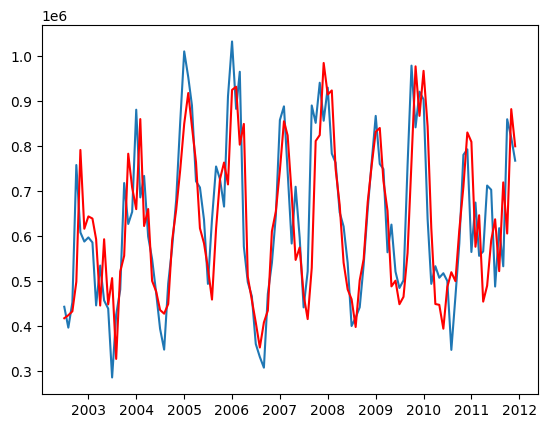

In [66]:
# plot forecasts against actual outcomes
plt.plot(df_merged_all_values.iloc[train_size:len(X)].index, test)
plt.plot(df_merged_all_values.iloc[train_size:len(X)].index, preds, color='red')
plt.show()

In [67]:
FORECAST_STEPS = 24
forecast = model_fit.forecast(steps=FORECAST_STEPS)

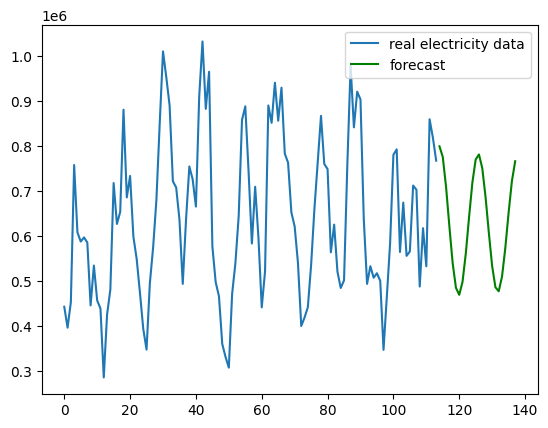

In [72]:
plt.plot(test, label="real electricity data")
plt.plot(range(len(test), len(test)+FORECAST_STEPS),forecast, color='green', label="forecast")
plt.legend()
plt.show()